In [1]:
import torch
from tqdm import tqdm
import cv2 as cv

from flow_net.flownet2_cuda.utils.flow_utils import * 

from OwnFlowNet2.FlowNet2 import FlowNet2
from utils.encoding import *
from utils.layers import *
from utils.plotting import *

import warnings

warnings.filterwarnings('ignore')

In [2]:
# load images
torch.manual_seed(10)

pat_indices = torch.cat((torch.arange(0, 17), torch.arange(18, 43)), 0)

rnd_perm_idc = torch.randperm(pat_indices.size(0))
pat_indices = pat_indices[rnd_perm_idc]
# train_set = pat_indices[:35]
# test_set = torch.cat((pat_indices[35:],torch.LongTensor([17])),0)

# Now, we prepare our train & test dataset.
test_set = torch.LongTensor([35, 41, 0, 4, 33, 38, 39, 17])
train_set = torch.arange(43)
for idx in test_set:
    train_set = train_set[train_set != idx]

print('Test_Set:', test_set)
print('Train_Set:', train_set)

Test_Set: tensor([35, 41,  0,  4, 33, 38, 39, 17])
Train_Set: tensor([ 1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20,
        21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 36, 37, 40, 42])


In [3]:
img = torch.load('/home/till/uni/masterArbeit/Tests/img.pth')
seg = torch.load('/home/till/uni/masterArbeit/Tests/seg.pth')
print("images loaded")

images loaded


In [4]:
# instanciate net
net = FlowNet2()
net.load_state_dict(torch.load("OwnFlowNet2/weights/FlowNet2_checkpoint.pth.tar")['state_dict'])

<All keys matched successfully>

## Show Flownet2 for one example

In [5]:
rnd_train_idx = torch.randperm(train_set.size(0))
fix = train_set[rnd_train_idx[0]]
mov = train_set[rnd_train_idx[1]]
fix = 10; mov = 15
#print(fix , mov)

img_fixed = img[fix:fix + 1, :, :].unsqueeze(1).float() / 255
img_moving = img[mov:mov + 1, :, :].unsqueeze(1).float() / 255
H, W = img_fixed.shape[-2:]

img_fixed_rgb = cv.cvtColor(np.asarray(img_fixed).squeeze(), cv.COLOR_GRAY2RGB)# .reshape(3, 320, 256)
img_moving_rgb = cv.cvtColor(np.asarray(img_moving).squeeze(), cv.COLOR_GRAY2RGB)# .reshape(3, 320, 256)

images = [img_fixed_rgb, img_moving_rgb]
images = np.array(images).transpose(3, 0, 1, 2)
im = torch.from_numpy(images.astype(np.float32)).unsqueeze(0)

In [6]:
net_output = net(im)
data = net_output.squeeze().data.cpu().numpy().transpose(1, 2, 0)
flow = net_output.detach()

In [7]:
#extract two segmentations and compute Dice
moving_seg = (seg[mov:mov+1,:,:]).long().contiguous()
fixed_seg = (seg[fix:fix+1,:,:]).long().contiguous()
d0 = dice_coeff(fixed_seg,moving_seg,8)
print(d0,d0.mean())

identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W),align_corners=False)
warped_seg = F.grid_sample(moving_seg.float().unsqueeze(1),identity+net_output.permute(0,2,3,1),mode='nearest',align_corners=False)
d1 = dice_coeff(fixed_seg,warped_seg.squeeze(),8)
print(d1,d1.mean())

tensor([0.1541, 0.7498, 0.1174, 0.0000, 0.5917, 0.7205, 0.4235]) tensor(0.3939)
tensor([0.0409, 0.0000, 0.0000, 0.0000, 0.3288, 0.0168, 0.0118]) tensor(0.0569)


## Visualize results.
It can be seen that the dice score from warped moving seg and fixed seg is similar to the dice score from moving seg and fixed seg, leading to the assumption, that little flow was used to warp the labels.

Having a look at the arped labels, they are not very accurate, for the given example

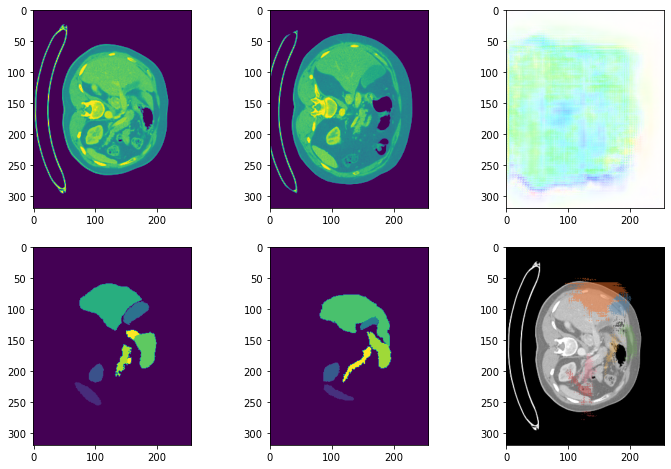

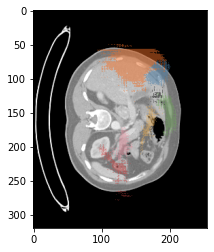

In [8]:
plt.figure(figsize=(12,8))
plt.subplot(231)
plt.imshow(img_fixed.squeeze())
plt.subplot(233)
plt.imshow(flow2img(data))
plt.subplot(232)
plt.imshow(img_moving.squeeze())
plt.subplot(234)
plt.imshow(seg[mov:mov+1,:,:].squeeze())
plt.subplot(235)
plt.imshow(seg[fix:fix+1,:,:].squeeze())
plt.subplot(236)
plt.imshow(overlaySegment(img_fixed.squeeze(),warped_seg.data.squeeze(),True))
plt.show()

Later I discovered,that the flow looks that bad, because the input images were normalides, and FlowNet2 expects a range from 0 to 255 

## Training loop for Flownet2, to train on the small image dataset
Just for experimenting how the net learns. 
First Experiment: using the whole dataset once, and showing all images from the training set once, in order to overcome the nan loss problem
- Adam optim gives nan loss after first step, regardless of the learning rate
- loss funciton of squarred error between warped labels and fixed labels does not lead to improvement



In [9]:
# init optim (run with SGD)
#del net
net = FlowNet2()
net.load_state_dict(torch.load("OwnFlowNet2/weights/FlowNet2_checkpoint.pth.tar")['state_dict'])

optimizer = torch.optim.Adam(list(net.parameters()), lr = 0.0025)
#optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
grad_accum = 20

net.train()
net.cuda()

# Identity matrix used for computation. 
H, W = img[0:1,:,:].shape[-2:]
identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W),align_corners=False)

epochs = np.arange(0,200)
loss_vals = []
# Iterate over all examples once
for epoch in epochs:
    
    # randomize selection
    rnd_train_idx = torch.randperm(train_set.size(0))
    p_fix = train_set[rnd_train_idx[0]]
    p_mov = train_set[rnd_train_idx[1]]
        
    # load images and transform them to RGB images
    img_fixed = img[p_fix:p_fix + 1, :, :].unsqueeze(1).float() / 255
    img_moving = img[p_mov:p_mov + 1, :, :].unsqueeze(1).float() / 255
    
    H, W = img_fixed.shape[-2:]
    
    img_fixed_rgb = cv.cvtColor(np.asarray(img_fixed).squeeze(), cv.COLOR_GRAY2RGB)# .reshape(3, 320, 256)
    img_moving_rgb = cv.cvtColor(np.asarray(img_moving).squeeze(), cv.COLOR_GRAY2RGB)# .reshape(3, 320, 256)

    # used from the code of the official flownet2 repo
    # https://github.com/NVIDIA/flownet2-pytorch
    images = np.asarray([img_fixed_rgb, img_moving_rgb]).transpose(3,0,1,2)
    im = torch.from_numpy(images.astype(np.float32)).unsqueeze(0)
    
    # estimatin flow with Flownet2
    flow_estimation = net(im.cuda()).cpu()
    
    # loading the two segmentations and comapre them
    fixed_seg = seg[p_fix:p_fix + 1, :, :].long().contiguous()
    moving_seg = seg[p_mov:p_mov + 1, :, :].long().contiguous()
    #d0 = dice_coeff(fixed_seg,moving_seg,8)
    
    # warping the fixed seg with the output of the flow net
    warped_seg = F.grid_sample(moving_seg.float().unsqueeze(1),identity+flow_estimation.permute(0,2,3,1),mode='nearest',align_corners=False).reshape(1,H,W)
    #plt.imshow(warped_seg.detach().squeeze().numpy())
    
    label_fixed = F.one_hot(fixed_seg, num_classes=9).permute(0, 3, 1, 2).float()
    _, C1, Hf, Wf = label_fixed.size()
    label_fixed = F.interpolate(label_fixed, size=(Hf, Wf), mode='bilinear').squeeze()
        
    label_warped = F.one_hot(warped_seg.to(torch.int64), num_classes=9).permute(0, 3, 1, 2).float()
    _, C1, Hf, Wf = label_warped.size()
    label_warped = F.interpolate(label_warped, size=(Hf, Wf), mode='bilinear').squeeze()
    
    # let us try to use the difference in dice as loss
    loss = torch.sum(torch.pow(label_fixed.reshape(9, -1) - label_warped.reshape(9, -1), 2), 0).mean()
    loss.requires_grad=True
    #print(loss)
    loss.cuda().backward()
    loss_vals.append(loss.cpu().item())
    
    if (epoch + 1) % grad_accum == 0:
        # every grad_accum iterations : backpropagate the accumulated gradients
        optimizer.step()
        optimizer.zero_grad()
        #print(loss.item())

plt.plot(epochs, loss_vals)

RuntimeError: CUDA out of memory. Tried to allocate 552.00 MiB (GPU 0; 3.82 GiB total capacity; 1.17 GiB already allocated; 2.44 MiB free; 1.19 GiB reserved in total by PyTorch)

## verdict
Leave Flownet2 as is, because sometimes it seems to be good. So definetly can be used for ensemble. If time: Train more

## Some more Exploration (06.05.21)
Finally was able to compile the cuda correlation layer, as well as other layers the lfownet uses. 
Therefore I want to explore the flownet cuda implementation, from https://github.com/NVIDIA/flownet2-pytorch together with the pretrained weights
Maybe, just maybe, I can finally fine tune it on the medical dataset

In [22]:
import argparse, os, sys, subprocess
import torch
#sys.path.insert(1, './flow_net')
from models.flownet2.models import FlowNet2
from models.flownet2.utils import tools
from models.flownet2 import models, losses
from models.flownet2.utils.flow_utils import *

from utils.encoding import dice_coeff
from utils.plotting import overlaySegment

In [2]:
parser = argparse.ArgumentParser()

parser.add_argument('--start_epoch', type=int, default=1)
parser.add_argument('--total_epochs', type=int, default=10000)
parser.add_argument('--batch_size', '-b', type=int, default=8, help="Batch size")
parser.add_argument('--train_n_batches', type=int, default = -1, help='Number of min-batches per epoch. If < 0, it will be determined by training_dataloader')
parser.add_argument('--crop_size', type=int, nargs='+', default = [256, 256], help="Spatial dimension to crop training samples for training")
parser.add_argument('--gradient_clip', type=float, default=None)
parser.add_argument('--schedule_lr_frequency', type=int, default=0, help='in number of iterations (0 for no schedule)')
parser.add_argument('--schedule_lr_fraction', type=float, default=10)
parser.add_argument("--rgb_max", type=float, default = 255.)

parser.add_argument('--number_workers', '-nw', '--num_workers', type=int, default=8)
parser.add_argument('--number_gpus', '-ng', type=int, default=-1, help='number of GPUs to use')
parser.add_argument('--no_cuda', action='store_true')

parser.add_argument('--seed', type=int, default=1)
parser.add_argument('--name', default='run', type=str, help='a name to append to the save directory')
parser.add_argument('--save', '-s', default='./work', type=str, help='directory for saving')

parser.add_argument('--validation_frequency', type=int, default=5, help='validate every n epochs')
parser.add_argument('--validation_n_batches', type=int, default=-1)
parser.add_argument('--render_validation', action='store_true', help='run inference (save flows to file) and every validation_frequency epoch')

parser.add_argument('--inference', action='store_true')
parser.add_argument('--inference_visualize', action='store_true',
                    help="visualize the optical flow during inference")
parser.add_argument('--inference_size', type=int, nargs='+', default = [-1,-1], help='spatial size divisible by 64. default (-1,-1) - largest possible valid size would be used')
parser.add_argument('--inference_batch_size', type=int, default=1)
parser.add_argument('--inference_n_batches', type=int, default=-1)
parser.add_argument('--save_flow', action='store_true', help='save predicted flows to file')

parser.add_argument('--resume', default='', type=str, metavar='PATH', help='path to latest checkpoint (default: none)')
parser.add_argument('--log_frequency', '--summ_iter', type=int, default=1, help="Log every n batches")

parser.add_argument('--skip_training', action='store_true')
parser.add_argument('--skip_validation', action='store_true')

parser.add_argument('--fp16', action='store_true', help='Run model in pseudo-fp16 mode (fp16 storage fp32 math).')
parser.add_argument('--fp16_scale', type=float, default=1024., help='Loss scaling, positive power of 2 values can improve fp16 convergence.')

tools.add_arguments_for_module(parser, models, argument_for_class='model', default='FlowNet2')

tools.add_arguments_for_module(parser, losses, argument_for_class='loss', default='L1Loss')

tools.add_arguments_for_module(parser, torch.optim, argument_for_class='optimizer', default='Adam', skip_params=['params'])

In [3]:
args, unknown = parser.parse_known_args()
net = FlowNet2(args)

In [5]:
net.load_state_dict(torch.load("models/flownet2/weights/FlowNet2_checkpoint.pth.tar")['state_dict'])

<All keys matched successfully>

In [15]:
fix = 10; mov = 15
#print(fix , mov)
img = torch.load('Data/img.pth')
seg = torch.load('Data/seg.pth')
img_fixed = img[fix:fix + 1, :, :].float()
img_moving = img[mov:mov + 1, :, :].float()
C,H,W = img_fixed.shape

fixed_seg = seg[fix:fix + 1, :, :]
moving_seg = seg[mov:mov + 1, :, :]

#img_fixed_rgb = cv.cvtColor(np.asarray(img_fixed).squeeze(), cv.COLOR_GRAY2RGB)# .reshape(3, 320, 256)
#img_moving_rgb = cv.cvtColor(np.asarray(img_moving).squeeze(), cv.COLOR_GRAY2RGB)# .reshape(3, 320, 256)
img_fixed = img_fixed.reshape(H,W,C).numpy()
img_moving= img_moving.reshape(H,W,C).numpy()

img_fixed = np.concatenate([img_fixed, img_fixed, img_fixed], 2)
img_moving = np.concatenate([img_moving, img_moving, img_moving], 2)

images = [img_fixed, img_moving]
images = np.array(images).transpose(3, 0, 1, 2)
im = torch.from_numpy(images.astype(np.float32)).unsqueeze(0)

In [10]:
net.cuda()
flow = net(im.cuda()).squeeze()

/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [11]:
data = flow.data.cpu().numpy().transpose(1,2,0)

In [12]:
data.shape

(320, 256, 2)

In [13]:
flowVis = flow2img(data)

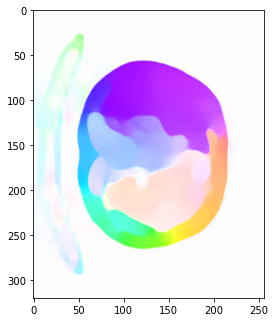

In [14]:
fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
plt.imshow(flowVis)

plt.imsave("FlowNet2-FlowVis.png", flowVis)

In [70]:
from utils.layers import warp
warpedSeg = warp(moving_seg.unsqueeze(0).float().cuda(), flow).detach().cpu()

In [71]:
d0 = dice_coeff(fixed_seg,warpedSeg,8)
print(d0,d0.mean())

tensor([0.7388, 0.8540, 0.5279, 0.0000, 0.7580, 0.7855, 0.3700]) tensor(0.5763)


In [89]:
test = img[fix:fix + 1, :, :].float() / 255

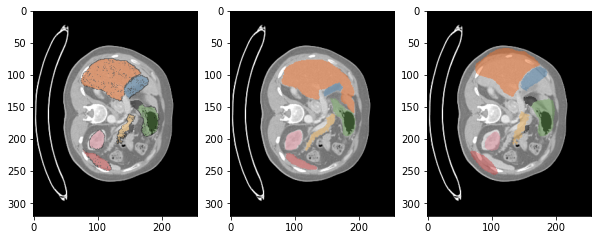

In [95]:
fig = plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(overlaySegment(test.squeeze(), warpedSeg.view(320,256))
plt.subplot(132)
plt.imshow(overlaySegment(test.squeeze(), fixed_seg.squeeze()))
plt.subplot(133)
plt.imshow(overlaySegment(test.squeeze(), moving_seg.squeeze()))

# Verdict
Looks good. Can be used